<a href="https://colab.research.google.com/github/danielscurlock/DS-Unit-1-Sprint-1-Data-Wrangling-and-Storytelling/blob/master/notebooks/Explanatory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Explanatory Analysis of 188 Million Wild Fires:**
by: ***Daniel Scurlock*** (3/2/20)


---



# *Dataset Description:*
https://www.kaggle.com/rtatman/188-million-us-wildfires

This data publication contains a spatial database of wildfires that occurred in the United States from 1992 to 2015. It is the third update of a publication originally generated to support the national Fire Program Analysis (FPA) system. The wildfire records were acquired from the reporting systems of federal, state, and local fire organizations. The following core data elements were required for records to be included in this data publication: discovery date, final fire size, and a point location at least as precise as Public Land Survey System (PLSS) section (1-square mile grid). The data were transformed to conform, when possible, to the data standards of the National Wildfire Coordinating Group (NWCG). Basic error-checking was performed and redundant records were identified and removed, to the degree possible. The resulting product, referred to as the Fire Program Analysis fire-occurrence database (FPA FOD), includes 1.88 million geo-referenced wildfire records, representing a total of 140 million acres burned during the 24-year period.


---


***I will try to be as thorough as possible. My goal here is to ask questions and exmplain those answers with visulalizations***

In [2]:
!pip install geoplot

     |████████████████████████████████| 51kB 3.9MB/s 
     |████████████████████████████████| 931kB 14.4MB/s 
     |████████████████████████████████| 8.9MB 19.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 /usr/local/lib/python3.6/dist-packages/pip/_vendor/pep517/_in_process.py get_requires_for_build_wheel /tmp/tmpqek9otce Check the logs for full command output.


In [0]:
# Get things ready for analysis
import pandas as pd
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr
import matplotlib.pyplot as plt
import descartes 
from shapely.geometry import Point, Polygon
import numpy as np

In [4]:
# Get the previously created CSV into place for tomorrow
df = pd.read_csv('/content/drive/My Drive/Lambda/DSU1-BUILD/data/firesfinal.csv', index_col=0 , infer_datetime_format=True)




/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
df.head()

,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,DATE,YEAR,MONTH,DAY,WEEKDAY,HEINSELMAN,STATE_NAME,REGION,DIVISION
0,Other,0.10,A,40.036944,-121.005833,CA,2005-02-02,2005,February,2,Wednesday,small,California,West,Pacific
1,Lightning,0.25,A,38.933056,-120.404444,CA,2004-05-12,2004,May,12,Wednesday,small,California,West,Pacific
2,Debris Burning,0.10,A,38.984167,-120.735556,CA,2004-05-31,2004,May,31,Monday,small,California,West,Pacific
3,Lightning,0.10,A,38.559167,-119.913333,CA,2004-06-28,2004,June,28,Monday,small,California,West,Pacific
4,Lightning,0.10,A,38.559167,-119.933056,CA,2004-06-28,2004,June,28,Monday,small,California,West,Pacific


# **A regional analysis of wildfires**
I will compare and contrast wildfire data based on region. I want to know the frequency of fires per region, and the average acreage burned. I want to identify the most frequest cause of of those fires per region. I also want to identify the months where fires are more frequent

In [0]:
from IPython.display import display, Image

# GRAB ME AN IMAGE, AND THEME OTHER THINGS ACCORDINGLY.
url = 'https://www.eia.gov/consumption/commercial/images/cendivco_new.gif'
regional = Image(url=url, width=500)


In [7]:
df.head()

,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,DATE,YEAR,MONTH,DAY,WEEKDAY,HEINSELMAN,STATE_NAME,REGION,DIVISION
0,Other,0.10,A,40.036944,-121.005833,CA,2005-02-02,2005,February,2,Wednesday,small,California,West,Pacific
1,Lightning,0.25,A,38.933056,-120.404444,CA,2004-05-12,2004,May,12,Wednesday,small,California,West,Pacific
2,Debris Burning,0.10,A,38.984167,-120.735556,CA,2004-05-31,2004,May,31,Monday,small,California,West,Pacific
3,Lightning,0.10,A,38.559167,-119.913333,CA,2004-06-28,2004,June,28,Monday,small,California,West,Pacific
4,Lightning,0.10,A,38.559167,-119.933056,CA,2004-06-28,2004,June,28,Monday,small,California,West,Pacific


In [8]:
df['FIRE_SIZE'].sum() / 100000000

1.3999386113268495

In [9]:
df.dtypes

STAT_CAUSE_DESCR     object
FIRE_SIZE           float64
FIRE_SIZE_CLASS      object
LATITUDE            float64
LONGITUDE           float64
STATE                object
DATE                 object
YEAR                  int64
MONTH                object
DAY                   int64
WEEKDAY              object
HEINSELMAN           object
STATE_NAME           object
REGION               object
DIVISION             object
dtype: object

In [10]:
# What kind of regions do we have?
df['REGION'].value_counts()

South        950358
West         589422
Midwest      178933
Northeast    139671
Name: REGION, dtype: int64

In [11]:
df['DIVISION'].value_counts()

South Atlantic        499379
Pacific               306889
Mountain              282533
West South Central    246936
East South Central    204043
West North Central    128666
Middle Atlantic       115531
East North Central     50267
New England            24140
Name: DIVISION, dtype: int64

In [12]:
display(regional)

In [0]:
# Subset for each region
south = df[df['REGION'] == 'South']
west = df[df['REGION'] == 'West']
midwest = df[df['REGION'] == 'Midwest']
northeast = df[df['REGION'] == 'Northeast']


# Statistical significance
looking for anything statistically significant in fires

In [0]:
# Want to perform from testing, both on numerical 
# and catagorical data.

# The first of which is the ttest on the size of the fire
# The t test tells us how significant the differences in 
# fire size is between regions, and if those differences 
# (measured in means/averages) could have happened by chance.

dfs = [[south, 'south'],
       [west, 'west'], 
       [midwest, 'midwest'], 
       [northeast, 'northeast']]


tmplist = []
for rega in dfs:
  for regb in dfs:
    if rega[1] != regb[1]:
      t, p = ttest_ind(rega[0]['FIRE_SIZE'], regb[0]['FIRE_SIZE'], nan_policy='omit')
      tmplist.append([rega[1], regb[1], abs(t), p])

tpdf = pd.DataFrame(tmplist, columns=['rega', 'regb', 't-vaule', 'p-value'])

tpdf['conclusion'] = ['fail to reject' if x >= 0.5 else 'reject' for x in tpdf['p-value']]

##Fires per year 


### Total Fires per year 
This visual emphasizes total fires per year, while showing their distrubution among regions

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


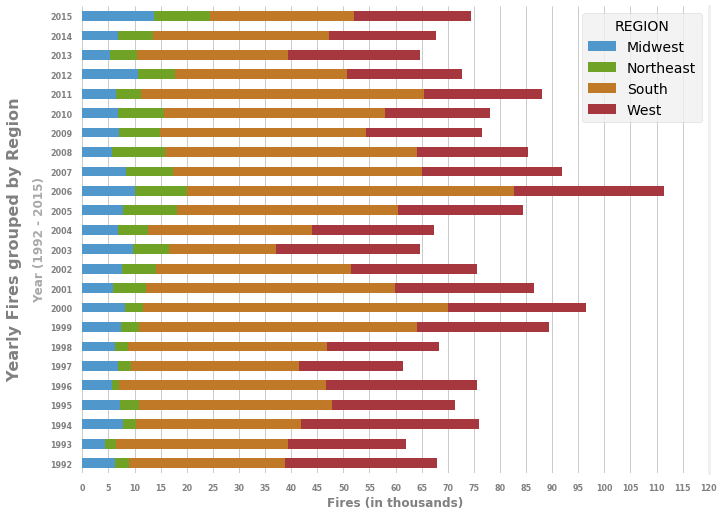

In [14]:
# Colors for stacks:
# Midwest = 5098CB
# Northeast = 70A225
# South = C07A27
# West = A7373F

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10,8)) 
dfyearbyregion = df.groupby(['YEAR','REGION']).size().unstack()
dfyearbyregion.plot(kind='barh',stacked=True, ax=ax, colors=['#5098CB', '#70A225', '#C07A27', '#A7373F'])

ax.set_title('Yearly Fires grouped by Region',
             rotation='vertical', 
             loc = 'left', 
             color = 'Grey', 
             fontsize=16, 
             fontweight = 'semibold', 
             x=-0.12, 
             y=0.19)

ax.set_xlabel('Fires (in thousands)', 
               color='Grey', 
               fontsize=12, 
               fontweight='bold')


# MY BRAIN WENT BLANK. I ACTUALLY FORGOT
# HOW TO DO THIS THE NOT RETARDED WAY. 
ax.set_xticks([0, 
               5000, 
               10000, 
               15000, 
               20000, 
               25000, 
               30000, 
               35000, 
               40000, 
               45000, 
               50000, 
               55000, 
               60000, 
               65000,
               70000,
               75000,
               80000,
               85000,
               90000,
               95000,
               100000,
               105000,
               110000,
               115000,
               120000])

ax.set_xticklabels(labels = ['0', '5','10', '15' ,'20', '25', '30', '35', '40', '45', '50',
                             '55','60', '65','70', '75', '80', '85', '90', '95', '100', '105',
                             '110','115','120'], 
                      rotation='horizontal', 
                      color='grey', 
                      fontsize=8,
                      fontweight='bold')

ax.set_ylabel('Year (1992 - 2015)', 
               color='DarkGrey', 
               fontsize=12, 
               fontweight='bold')

ax.set_yticklabels(labels = ['1992','1993','1994','1995','1996','1997','1998',
                             '1999','2000','2001','2002','2003','2004','2005',
                             '2006','2007', '2008','2009','2010','2011','2012',
                             '2013','2014','2015'], 
                      color='grey', 
                      fontsize=8,
                      fontweight='bold')

# Border removal
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Grid
ax.grid(axis='y')

# Need some padding for the tick labels it looks like
ax.tick_params(axis='both', which='major', pad=10)

fig.patch.set(facecolor='white')
ax.set(facecolor='white')

plt.show()

### Acreage per year

In [17]:
tpdf.head(20)

,rega,regb,t-vaule,p-value,conclusion
0,south,west,34.088523,1.359087e-254,reject
1,south,midwest,2.138238,3.249762e-02,reject
2,south,northeast,8.725730,2.648306e-18,reject
3,west,south,34.088523,1.359087e-254,reject
4,west,midwest,14.917556,2.575363e-50,reject
5,west,northeast,15.940912,3.369421e-57,reject
6,midwest,south,2.138238,3.249762e-02,reject
7,midwest,west,14.917556,2.575363e-50,reject
8,midwest,northeast,16.681996,1.883756e-62,reject
9,northeast,south,8.725730,2.648306e-18,reject


The results of the ttests were pretty straight forward. There is a statistically significant difference between regions when it comes to the amount of acreage burned during a wildfire. Though the difference varied. This is probably because of the distace between regions. The biggest difference is between the south and the west. I can use that information. 

In [0]:
# Building us a dataframe to show region
# number of fires, and mean acerage, and 
# plot this

regions = ['South', 'West', 'Midwest', 'Northeast']

tmp = []

for r in regions:
  tmpdf = df[df['REGION'] == r]
  
  total_fires = tmpdf['REGION'].value_counts().sum()
  total_acres = tmpdf['FIRE_SIZE'].sum() / 100000000 # Get the number in trillions
  mean_size = tmpdf['FIRE_SIZE'].mean()
  tmp.append([r, total_acres, mean_size])

regdf = pd.DataFrame(tmp, columns=['Region', 
                                   'Total Acreage',
                                   'Mean' 
                                   ])



In [19]:
regdf.head()

,Region,Total Acreage,Mean
0,South,0.260355,27.395502
1,West,1.077219,182.758497
2,Midwest,0.059081,33.018378
3,Northeast,0.003284,2.351031


I can see now that, while more fires occured in the south, the size of those fires were signiicantly smaller than those from the west. This explains the high t-vales from above. Getting some data for total fires by region, and adding info
concerning total acreage and mean fire size for plotting. 

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


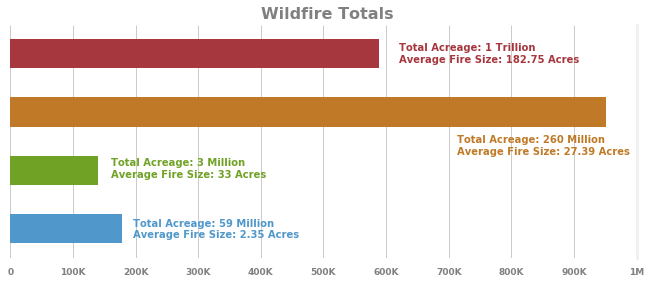

In [20]:
# Colors for stacks:
# Midwest = 5098CB
# Northeast = 70A225
# South = C07A27
# West = A7373F

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10,4)) 
dfyearbyregion = df.groupby(['REGION']).size()
bar_plot = dfyearbyregion.plot(kind='barh', ax=ax, colors=['#5098CB', '#70A225', '#C07A27', '#A7373F'])

ax.set_title('Wildfire Totals', 
             loc = 'left', 
             color = 'Grey', 
             fontsize=16, 
             fontweight = 'semibold', 
             x=.4, 
             y=1)

ax.set_xlabel('', 
               color='Grey', 
               fontsize=12, 
               fontweight='bold')
ax.set_xticks([0, 
               100000, 
               200000, 
               300000, 
               400000, 
               500000, 
               600000, 
               700000, 
               800000, 
               900000, 
               1000000])

ax.set_xticklabels(labels = ['0', '100K','200K', '300K' ,'400K', '500K', '600K', '700K', '800K', '900K', '1M'], 
                      rotation='horizontal', 
                      color='grey', 
                      fontsize=9,
                      fontweight='bold')



ax.set_ylabel('', 
               color='DarkGrey', 
               fontsize=12, 
               fontweight='bold')

ax.set_yticklabels(labels = [], 
                      color='grey', 
                      fontsize=8,
                      fontweight='bold')

# Border removal
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Grid
ax.grid(axis='y')




# Need some padding for the tick labels it looks like
ax.tick_params(axis='both', which='major', pad=10)

fig.patch.set(facecolor='white')
ax.set(facecolor='white')

# From my analysis above, I can add the total acreage to these bars
# to give an idea of how severe fires are in each reagion
# West = 1.077219 Trillion acres
# South = 260.355341 Million Acres
# Northeast = 3.283709 Million
# Midwest = 59.080775 Million


fig.text(s ='Total Acreage: 1 Trillion\nAverage Fire Size: 182.75 Acres', 
        x=0.62, 
        y=.75, 
        fontsize=10, 
        color='#A7373F', 
        fontweight='bold')


fig.text(s ='Total Acreage: 260 Million\nAverage Fire Size: 27.39 Acres', 
        x=0.7, 
        y=.43, 
        fontsize=10, 
        color='#C07A27', 
        fontweight='bold')




fig.text(s ='Total Acreage: 3 Million\nAverage Fire Size: 33 Acres', 
        x=0.22, 
        y=.35, 
        fontsize=10, 
        color='#70A225', 
        fontweight='bold')



fig.text(s ='Total Acreage: 59 Million\nAverage Fire Size: 2.35 Acres', 
        x=0.25, 
        y=.14, 
        fontsize=10, 
        color='#5098CB', 
        fontweight='bold')



plt.show()

### Over Time
This visual shows the progression of fires over time for each region

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


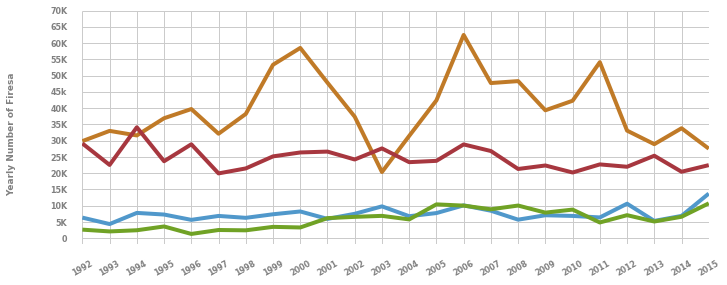

In [15]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10,4)) 
dfyearbyregion = df.groupby(['YEAR','REGION']).size().unstack()
dfyearbyregion.plot(kind='line', ax=ax, colors=['#5098CB', '#70A225', '#C07A27', '#A7373F'])

ax.set_title('Yearly Number of Firesa',
             rotation='vertical', 
             loc = 'left', 
             color = 'Grey', 
             fontsize=9, 
             fontweight = 'semibold', 
             x=-0.12, 
             y=0.19)

ax.set_ylabel('', 
               color='Grey', 
               fontsize=12, 
               fontweight='bold')


# MY BRAIN WENT BLANK. I ACTUALLY FORGOT
# HOW TO DO THIS THE NOT RETARDED WAY. 
ax.set_yticks([0,
               5000,                
               10000, 
               15000, 
               20000, 
               25000, 
               30000, 
               35000, 
               40000, 
               45000, 
               50000, 
               55000, 
               60000, 
               65000,
               70000])

ax.set_yticklabels(labels = ['0','5K', '10K','15K', '20K','25K', '30K','35K','40K', '45k',
                             '50K', '55K', '60K', '65K', '70K'], 
                      rotation='horizontal', 
                      color='grey', 
                      fontsize=8,
                      fontweight='bold')

ax.set_xlabel('', 
               color='DarkGrey', 
               fontsize=12, 
               fontweight='bold')

ax.set_xticks([1992,1993,1994,1995,1996,1997,1998,
               1999,2000,2001,2002,2003,2004,2005,
               2006,2007, 2008,2009,2010,2011,2012,
               2013,2014,2015])



ax.set_xticklabels(labels = ['1992','1993','1994','1995','1996','1997','1998',
                             '1999','2000','2001','2002','2003','2004','2005',
                             '2006','2007', '2008','2009','2010','2011','2012',
                             '2013','2014','2015'], 
                      color='grey', 
                      fontsize=8,
                      fontweight='bold',
                      rotation=30)

# Border removal
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)



# Need some padding for the tick labels it looks like
ax.tick_params(axis='both', which='major', pad=15)

fig.patch.set(facecolor='white')
ax.set(facecolor='white')
ax.get_legend().remove()
plt.show()

# Per region analysis
I will, in the time I have left, attempt to go over statistical information on a per-region basis. I just want states, months, and causes for each region. I think I have enough above to accuratly portray the big picture. I had really hoped on decending into divisions, doing more statistical testing, and APPLYING all the things I have learned from UNIT 1. 

In [0]:
# By Month - build the monthly dataframe

months = ['January', 
          'February', 
          'March', 
          'April', 
          'May', 
          'June', 
          'July', 
          'August', 
          'September', 
          'October', 
          'November', 
          'December']

regions = ['West', 'South', 'Northeast', 'Midwest']
tmp = []

for m in months:
  
  mdf = df[df['MONTH'] == m]
  
  counts = []
  counts.append(m)
  for r in regions:
    
    rdf = mdf[mdf['REGION'] == r]
    fires = len(rdf['REGION'])
    acreage = rdf['FIRE_SIZE'].sum()
    mean = rdf['FIRE_SIZE'].mean()
    
    fclass = rdf['FIRE_SIZE_CLASS'].count()
    
    
    counts.append(fires)
    counts.append(acreage)
    counts.append(mean)
  
  tmp.append(counts)


bymonthdf = pd.DataFrame(tmp, columns=['Month', 
                                       'WestFires', 
                                       'WestAcreage',
                                       'WestMean',
                                       'SouthFires',
                                       'SouthAcreage',
                                       'SouthMean',
                                       'NortheastFires',
                                       'NortheastAcreage',
                                       'NortheastMean',
                                       'MidwestFires',
                                       'MidwestAcreage',
                                       'MidwestMean'])

# God i hope that calculated correctly


In [22]:
bymonthdf.head(100)

,Month,WestFires,WestAcreage,WestMean,SouthFires,SouthAcreage,SouthMean,NortheastFires,NortheastAcreage,NortheastMean,MidwestFires,MidwestAcreage,MidwestMean
0,January,7727,2.396060e+05,31.008927,80134,1.548823e+06,19.327908,2120,1458.782300,0.688105,3621,8.840698e+04,24.415072
1,February,7600,4.409147e+05,58.015092,126821,2.817033e+06,22.212673,3123,3026.336000,0.969048,5641,2.856737e+05,50.642386
2,March,15129,9.940735e+05,65.706491,176093,4.834151e+06,27.452260,13929,21431.181890,1.538602,23552,9.206065e+05,39.088253
3,April,25544,1.453555e+06,56.903955,115084,5.426512e+06,47.152623,39911,145219.678496,3.638588,53662,1.345635e+06,25.076132
4,May,50634,6.778981e+06,133.882002,63791,2.594895e+06,40.678072,22969,72345.477100,3.149701,25854,4.325651e+05,16.731070
5,June,86955,3.235857e+07,372.130121,56218,2.197306e+06,39.085452,9651,18045.753600,1.869833,9996,1.391213e+05,13.917697
6,July,152211,3.130402e+07,205.662029,56191,1.203972e+06,21.426416,12053,15404.621200,1.278074,16094,6.707806e+05,41.678927
7,August,131778,2.657758e+07,201.684491,54508,1.316949e+06,24.160647,10304,21525.425559,2.089036,11520,8.068206e+05,70.036506
8,September,62548,4.515012e+06,72.184747,53200,1.031741e+06,19.393637,7772,6147.437400,0.790972,8239,5.020569e+05,60.936628
9,October,30788,2.589597e+06,84.110590,58024,8.169395e+05,14.079338,5694,9270.954800,1.628197,10256,4.660440e+05,45.441112


## Monthly Totals

In [0]:
monthlytotalsdf = bymonthdf[['Month', 'WestFires', 'SouthFires', 'NortheastFires', 'MidwestFires']]

In [26]:
monthlytotalsdf.head()

,Month,WestFires,SouthFires,NortheastFires,MidwestFires
0,January,7727,80134,2120,3621
1,February,7600,126821,3123,5641
2,March,15129,176093,13929,23552
3,April,25544,115084,39911,53662
4,May,50634,63791,22969,25854


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


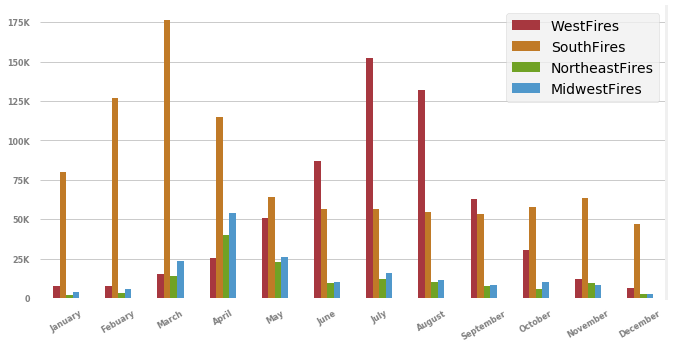

In [27]:
# Colors for stacks:
# Midwest = 5098CB
# Northeast = 70A225
# South = C07A27
# West = A7373F

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10,5)) 

monthlytotalsdf.plot(kind='bar', ax=ax, colors=['#A7373F', '#C07A27', '#70A225', '#5098CB' ])
# ['#5098CB', '#70A225', '#C07A27', '#A7373F']

ax.set_title('',
             rotation='vertical', 
             loc = 'left', 
             color = 'Grey', 
             fontsize=16, 
             fontweight = 'semibold', 
             x=-0.12, 
             y=0.19)

ax.set_xlabel('', 
               color='Grey', 
               fontsize=12, 
               fontweight='bold')


# MY BRAIN WENT BLANK. I ACTUALLY FORGOT
# HOW TO DO THIS THE NOT RETARDED WAY. 


ax.set_xticklabels(labels = ['January', 'Febuary','March', 'April', 'May' ,'June', 
                             'July', 'August', 'September', 'October', 'November', 'December'], 
                      rotation='30', 
                      color='grey', 
                      fontsize=8,
                      fontweight='bold')

ax.set_ylabel('', 
               color='DarkGrey', 
               fontsize=12, 
               fontweight='bold')

ax.set_yticklabels(labels = ['0','25K', '50K','75K','100K','125K','150K', '175K'], 
                      color='grey', 
                      fontsize=8,
                      fontweight='bold')

# Border removal
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Grid
ax.grid(axis='x')

# Need some padding for the tick labels it looks like
ax.tick_params(axis='both', which='major', pad=10)

fig.patch.set(facecolor='white')
ax.set(facecolor='white')



plt.show()

## Monthly Acreage

In [0]:
# Monthly totals
monthlyacreagedf = bymonthdf[['Month', 'WestAcreage', 'SouthAcreage', 'NortheastAcreage', 'MidwestAcreage']]

In [29]:
monthlyacreagedf.head()

,Month,WestAcreage,SouthAcreage,NortheastAcreage,MidwestAcreage
0,January,2.396060e+05,1.548823e+06,1458.782300,8.840698e+04
1,February,4.409147e+05,2.817033e+06,3026.336000,2.856737e+05
2,March,9.940735e+05,4.834151e+06,21431.181890,9.206065e+05
3,April,1.453555e+06,5.426512e+06,145219.678496,1.345635e+06
4,May,6.778981e+06,2.594895e+06,72345.477100,4.325651e+05


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


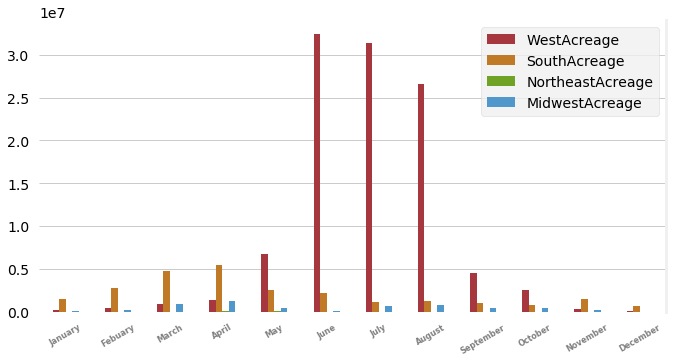

In [31]:
# Colors for stacks:
# Midwest = 5098CB
# Northeast = 70A225
# South = C07A27
# West = A7373F

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10,5)) 

monthlyacreagedf.plot(kind='bar', ax=ax, colors=['#A7373F', '#C07A27', '#70A225', '#5098CB' ])
# ['#5098CB', '#70A225', '#C07A27', '#A7373F']

ax.set_title('',
             rotation='vertical', 
             loc = 'left', 
             color = 'Grey', 
             fontsize=16, 
             fontweight = 'semibold', 
             x=-0.12, 
             y=0.19)

ax.set_xlabel('', 
               color='Grey', 
               fontsize=12, 
               fontweight='bold')


# MY BRAIN WENT BLANK. I ACTUALLY FORGOT
# HOW TO DO THIS THE NOT RETARDED WAY. 


ax.set_xticklabels(labels = ['January', 'Febuary','March', 'April', 'May' ,'June', 
                             'July', 'August', 'September', 'October', 'November', 'December'], 
                      rotation='30', 
                      color='grey', 
                      fontsize=8,
                      fontweight='bold')

ax.set_ylabel('', 
               color='DarkGrey', 
               fontsize=12, 
               fontweight='bold')


# Border removal
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Grid
ax.grid(axis='x')

# Need some padding for the tick labels it looks like
ax.tick_params(axis='both', which='major', pad=10)

fig.patch.set(facecolor='white')
ax.set(facecolor='white')



plt.show()

In [0]:
# Build the causes Dataframe
df['STAT_CAUSE_DESCR'].unique()

In [0]:
causes = ['Lightning', 
          'Debris Burning', 
          'Campfire',
          'Equipment Use', 
          'Children', 
          'Arson', 
          'Smoking', 
          'Railroad',
          'Fireworks', 
          'Structure', 
          'Powerline',
          'Other']

regions = ['West', 'South', 'Northeast', 'Midwest']
tmp = []

for c in causes:
  
  cdf = df[df['STAT_CAUSE_DESCR'] == c]
  
  counts = []
  counts.append(c)
  for r in regions:
    
    cadf = cdf[cdf['REGION'] == r]
    fires = len(cadf['REGION'])
    acreage = cadf['FIRE_SIZE'].sum()
    mean = cadf['FIRE_SIZE'].mean()
    counts.append(fires)
    counts.append(acreage)
    counts.append(mean)
  
  tmp.append(counts)


bycausedf = pd.DataFrame(tmp, columns=['Cause', 
                                       'WestFires', 
                                       'WestAcreage',
                                       'WestMean',
                                       'SouthFires',
                                       'SouthAcreage',
                                       'SouthMean',
                                       'NortheastFires',
                                       'NortheastAcreage',
                                       'NortheastMean',
                                       'MidwestFires',
                                       'MidwestAcreage',
                                       'MidwestMean'])         

In [0]:
bycausedf.head(200)

The NIFC classifies wildfires based on ignition source. The two primary ignition sources are lightning strikes and humans. A wildfire is classified as human-caused and can begin via “debris burning, campfires, arson, discarded smoking products, sparks from equipment in operation, arced power lines, and other means.”

For easier graphing, I will make sure there is only 2 catagories, nature(lightning), and human(all other).

In [0]:
causetotalsdf = bycausedf[['Cause', 'WestFires', 'SouthFires', 'NortheastFires', 'MidwestFires']]

In [0]:
causetotalsdf.head()

In [0]:
# Colors for stacks:
# Midwest = 5098CB
# Northeast = 70A225
# South = C07A27
# West = A7373F

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10,10)) 

causetotalsdf.plot(kind='bar', ax=ax, colors=['#A7373F', '#C07A27', '#70A225', '#5098CB' ])
# ['#5098CB', '#70A225', '#C07A27', '#A7373F']



# Border removal
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Grid
ax.grid(axis='x')

# Need some padding for the tick labels it looks like
ax.tick_params(axis='both', which='major', pad=10)

fig.patch.set(facecolor='white')
ax.set(facecolor='white')



plt.show()